In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcdefaults()
sns.set_theme()
sns.set_context("paper")
# sns.set_theme(style="whitegrid")
bgcolor = '#fff0f3' # "#edf2fb", "fff0f3" ["feeafa"]

plt.rcdefaults()

plt.rcParams['axes.facecolor'] = bgcolor
plt.rcParams['savefig.facecolor'] = "edf2fb"


from adjustText import adjust_text
import random

from config import parse_proteins_in_file

import os 
os.getcwd()

'/home/selezov_su/notebooks/Promics/Panoram'

In [2]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [3]:
values = pd.read_csv("Data/smears_imputed.csv", index_col=0, header=[0, 1, 2]).T.astype(int)

data = values.reset_index().drop(["Condition", "Acuteness"], axis=1).set_index("Sample")
metadata = values.reset_index().set_index("Sample")[["Condition", "Acuteness"]]

inference = DefaultInference(n_cpus=16)

dds = DeseqDataSet(
    counts=data,
    metadata=metadata,
    design_factors=["Condition"],
    inference=inference,
    refit_cooks=True,
)

dds.deseq2()

stat_res = DeseqStats(dds, inference=inference)

stat_res.summary()
deps = stat_res.results_df

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.08 seconds.

Fitting dispersion trend curve...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.07 seconds.

Fitting LFCs...
... done in 0.06 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 5 outlier genes.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 0.07 seconds.



Log2 fold change & Wald test p-value: Condition Pneumonia vs Healthy
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Protein IDs                                                               
A0A075B6P5   4.021980e+07       -1.429701  0.647994 -2.206348  0.027360   
Q99880       2.935146e+07        1.953248  0.476004  4.103424  0.000041   
O75592       4.057267e+06       -0.785698  0.514695 -1.526531  0.126878   
P00338       7.517038e+06       -0.196740  0.337151 -0.583539  0.559531   
P00450       4.914607e+06       -0.355465  0.498731 -0.712738  0.476008   
...                   ...             ...       ...       ...       ...   
Q15365       4.063583e+06       -0.317593  0.394025 -0.806023  0.420230   
Q6P5S2       1.038548e+07        0.420378  0.607700  0.691751  0.489094   
Q8N4F0       5.474854e+06        0.580971  0.345353  1.682253  0.092520   
Q8TDL5       7.046638e+06        0.866659  0.449828  1.926644  0.054024   
Q9H6R0       6.693592e+06      

In [4]:
from UniProtMapper import ProtMapper

de = deps.loc[deps["padj"] < 0.05]

mapper = ProtMapper()

result, failed = mapper.get(
    ids=de.index.to_list(), from_db="UniProtKB_AC-ID", to_db="Gene_Name"
)

with open("Data/de_genes.txt", 'w') as file:
    file.write("\n".join(result["To"]))

de = de.merge(result, left_index=True, right_on="From")
de.to_excel("Data/de_genes.xlsx")

Setting fields to `None` to retrieve all available fields...


Fetched: 28 / 28


In [5]:
def sign_func(row, fc=2):
    if float(row['padj']) <= 0.05:
        if row["log2FoldChange"] > fc: return "Up-regulated"
        
        elif row["log2FoldChange"] < -fc: return "Down-regulated"
        
        else: return "Significant"
    else:
        return "Not significant"
    

deps["Significance"] = deps.apply(sign_func, axis=1)
deps["-log10.padj"] = deps["padj"].map(lambda x: -np.log10(x))


with open("Data/de_proteins.txt", 'w') as file:
    file.write("\n".join(deps.loc[deps.padj <= 0.05].index.to_list()))

deps.to_csv("Data/smears_deps.csv", index=True)
deps.loc[deps.padj < 0.05].to_csv("Data/significant.csv", index=True)

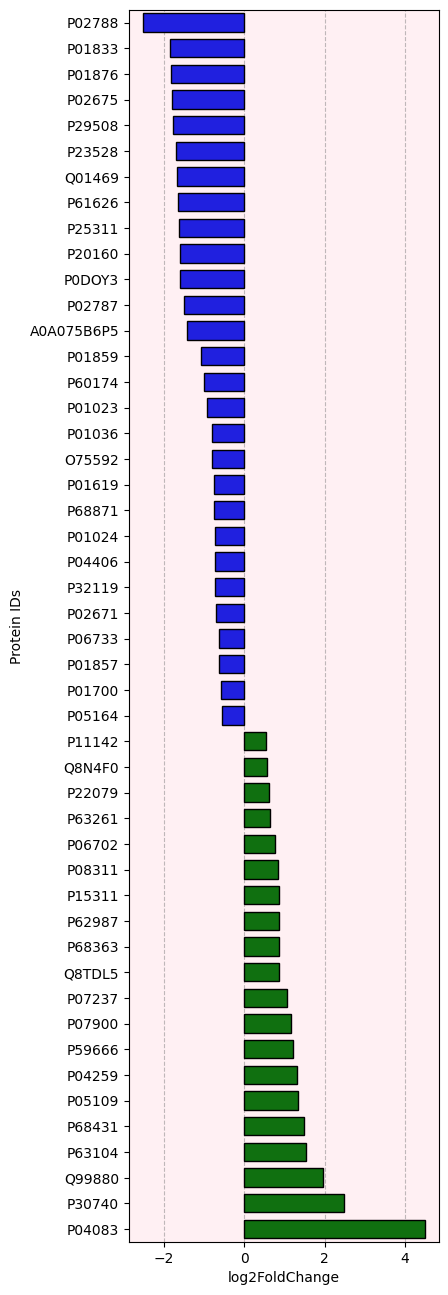

In [6]:
barplot_data = deps.loc[deps["log2FoldChange"].abs() > 0.5].reset_index().sort_values("log2FoldChange").reset_index()
barplot_data["color"] = barplot_data["log2FoldChange"].map(lambda x: "Down-regulated" if x <= 0 else "Up-regulated") 


# Bar plot
fig, ax = plt.subplots(figsize=(4, 16))

ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed', alpha=0.5)

sns.barplot(
    data=barplot_data,
    x="log2FoldChange", 
    y="Protein IDs", 
    label="Protein IDs",
    hue="color",
    palette=["blue", "green"],
    orient="h",
    legend=False,
    edgecolor="black",
    # edgewidth=0.5,
    gap=0.1
)

# sns.despine(left=True, bottom=True)
fig.savefig("Plots/difference.png", bbox_inches="tight", dpi=200)

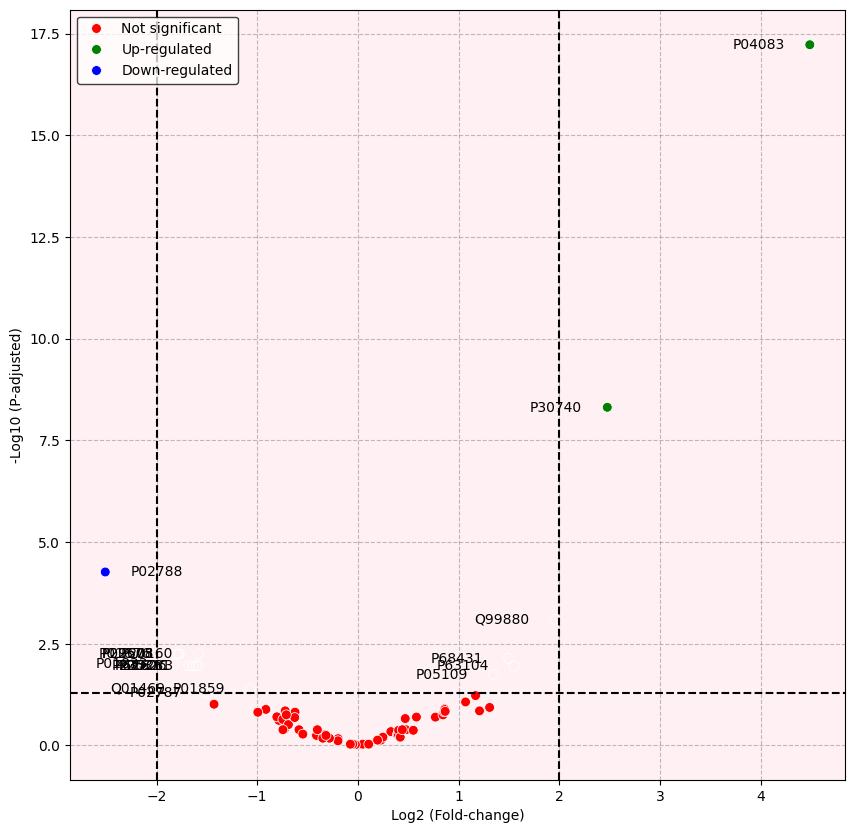

In [8]:
## Volcano plot
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed', alpha=0.5)

sns.scatterplot(
    data=deps,
    x="log2FoldChange",
    y="-log10.padj",
    hue="Significance",
    palette=["red", "green", "blue"],
    hue_order=["Not significant", "Up-regulated", "Down-regulated"],
    legend="full",
    s=50,
)


for i,r in deps.loc[deps.Significance != "Not significant"].iterrows():
    plt.text(x=r['log2FoldChange'] + (0.25 if r["Significance"] == "Down-regulated" else -0.25), y=r['-log10.padj'], s=i, va="center", ha = "left" if r["Significance"] == "Down-regulated" else "right")
# adjust_text(texts,arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.xlabel("Log2 (Fold-change)")
plt.ylabel("-Log10 (P-adjusted)")

plt.axvline(-2,color="black",linestyle="--")
plt.axvline(2,color="black",linestyle="--")
plt.axhline(-np.log10(0.05),color="black",linestyle="--")

# plt.grid(True)
plt.legend(
    loc="upper left",
    facecolor='white', 
    edgecolor="black",
    framealpha=0.75, 
)

fig.savefig("Plots/volcano.png", bbox_inches="tight", dpi=200)

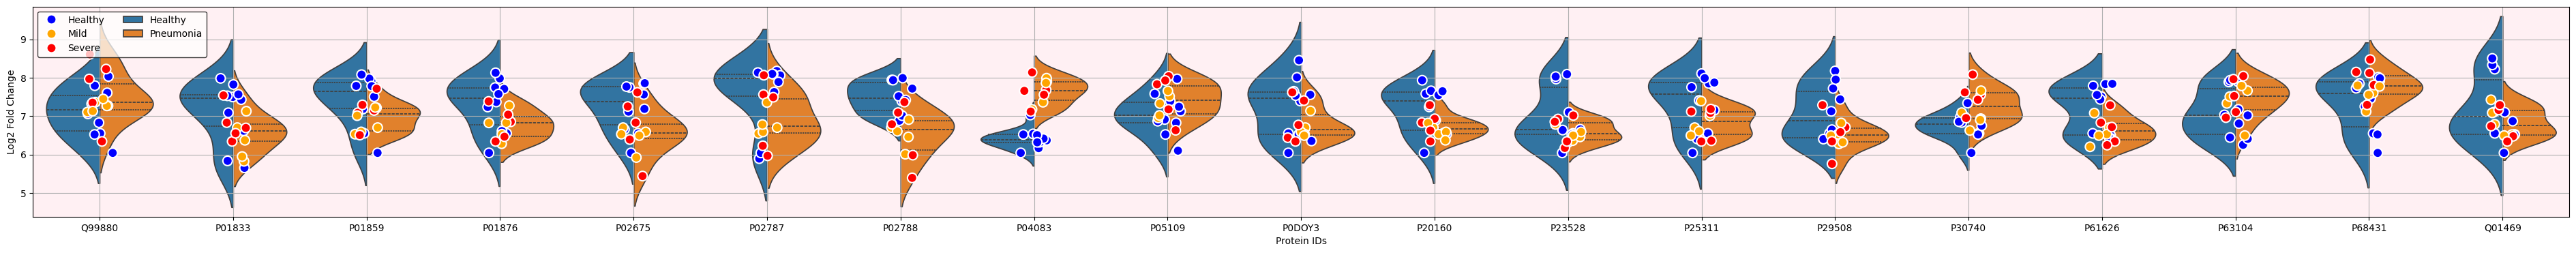

In [60]:
# Violine plot
violines = data.T.loc[deps.loc[deps.padj < 0.05].index]
violines = violines.stack().reset_index().merge(metadata, left_on="Sample", right_index=True).rename(columns={0 : "Value"})
violines["Value"] = violines["Value"].map(np.log10)

from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(48, 4))

sns.stripplot(data=violines, x='Protein IDs', y='Value', hue='Acuteness', hue_order=["Healthy", "Mild", "Severe"], palette=["blue", "orange", "red"], s=10, alpha=1, edgecolor="white", linewidth=1.5)
sns.violinplot(data=violines, x='Protein IDs', y='Value', hue='Condition', split=True, inner="quart", fill=True, alpha=1, density_norm="width")

ax.grid(True)
ax.set_ylabel("Log2 Fold Change")

plt.legend(
    ncol=2,
    loc="upper left",
    facecolor='white',
    edgecolor="black",
    framealpha=0.75, 
)

fig.savefig("Plots/violins.png", bbox_inches="tight", dpi=200)